# Utils

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import glob
from collections import defaultdict

# plt.rcParams['figure.figsize'] = [17, 5]
plt.rcParams['figure.figsize'] = [6.4, 4.8]

def read_csv(path, substrings=None, max_iters=None):
    
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    if substrings is not None:
        for substring in substrings:
            filenames = [f for f in filenames if substring in f ]
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(filename, engine='python').select_dtypes(['number']) for filename in filenames]
    # Make sure that all dfs have the same number of trajectories
    if max_iters is not None:
        dfs_list = [df[:max_iters] for df in dfs_list]
    return dfs_list, filenames
    
    
def create_average_df(path, substrings=None, max_iters=None, kpis=None):
    
    dfs_list, filenames = read_csv(path, substrings, max_iters)
    # Adding the filename to each dataframe
    for df, filename in zip(dfs_list, filenames):
      df['Filename'] = filename
    # Combine the list of dataframes, on top of each other
    combo_df = pd.concat(dfs_list, ignore_index=True, sort=False)
    if kpis is None:
        # Set kpis equal to the list of column names except 'Filename'
        kpis = combo_df.columns[:-1]
    n_files = len(filenames)
    means = defaultdict(list)
    for kpi in kpis:
        for it in range(max_iters):
            means[kpi].append(np.array([combo_df[kpi][it + f*max_iters] for f in range(n_files)]).mean())
    df_out = pd.DataFrame.from_dict(means)
    return df_out, filenames, combo_df, dfs_list

def extract_float(s):
    # Extract numbers from garbage string:
    newstr = ''.join((ch if ch in '0123456789.-e' else ' ') for ch in str(s))
    listOfNumbers = [float(i) for i in newstr.split()]
    listOfNumbers = listOfNumbers[0]
    return listOfNumbers

def clean_df(df, str_columns):
    # Transform string columns into floats if there is any 
    fu = lambda x: extract_float(x)
    for column in str_columns:
        df[column] = pd.Series(list(map(extract_float, df[column].astype(str).values)))
    return df

def clean_csv(path, str_columns):
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(f) for f in filenames]
    for df, filename in zip(dfs_list, filenames):
        df = clean_df(df, str_columns)
        df.to_csv("{}".format(filename))
    return dfs_list

def plot_data(path, key='ReturnLastEpisode'):
    df = pd.read_csv(path)
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mean = df[key]
    ax.plot(df['Iteration'], mean)
    return fig

def plot_all(dfs, key='AvgRet', ylim=None, scale='Samples'):
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for df in dfs:
        value = df[key]
        ax.plot(df[scale+'SoFar'], value)
    return fig

def compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None,
            scale='Iteration', title=None, xlabel=None, ylabel=None, grid=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    entries = []
    for candidate_name in candidates:
        entries.append(candidate_name)
        dfs = candidates[candidate_name]
        n_runs = len(dfs)
        mean_df, std_df = moments(dfs)
        mean = mean_df[key]
        std = std_df[key]
        ax.plot(mean_df[scale], mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
        print(candidate_name, end=': ')
        print_ci(dfs, conf, key)
    ax.legend(entries, loc='upper left')
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
        if ylabel is None:
            plt.ylabel(key)
        else:
            plt.ylabel(ylabel)
    if grid: plt.grid(linestyle='--', linewidth=0.5)
    return fig

# Calculate, plot and save confidence intervals

def moments(dfs):
    concat_df = pd.concat(dfs, axis=1)
    mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
    std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()
    return mean_df, std_df

def plot_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None, grid=True):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if isinstance(scale, str):
        ax.plot(mean_df[scale], mean)
    else: # it is possiple to pass a list of ordinates
        ax.plot(scale, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    if isinstance(scale, str):
         ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
    else: # it is possiple to pass a list of ordinates
        ax.fill_between(scale, interval[0], interval[1], alpha=0.3)
   
    if ylim: ax.set_ylim(ylim)
    if title is None:
        title = key
    else:
        title = key + ' - ' + title
    ax.set_title(title)
    if grid: plt.grid(linestyle='--', linewidth=0.5)
    return fig

def print_ci(dfs, conf=0.95, key='ReturnLastEpisode'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    total_horizon = len(mean_df)
    mean = mean_df[key][len(mean_df)-1]
    std = std_df[key][len(mean_df)-1]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    print('%f \u00B1 %f\t[%f, %f]\t total horizon: %d' % (mean, std, interval[0], interval[1], int(total_horizon)))

def save_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', horizon=1000, filename='prova.csv'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    low = pd.Series(interval[0])
    high = pd.Series(interval[1])
    iteration = pd.Series(horizon*np.array(range(len(mean))))
    df_out = pd.DataFrame(list(zip(iteration, mean, std, low, high)), columns=['iteration', 'mean', 'std', 'low', 'up'])
    df_out.to_csv(filename, index=False)
    
def find_max(dfs_list, key):
    maximum = 0
    for df in dfs_list:
        maximum_i = df['ReturnMax'].max()
        if maximum_i > maximum:
            maximum = maximum_i
    return maximum

def save_plot(fig, dir='.', fname='test'):
    fname = dir + '/' + fname + '.pdf'
    fig.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    return

# LQG - 1D

## Mu only

GPUCB: 138.101587 ± 73.000832	[110.842628, 165.360546]	 total horizon: 5000
UCB1: 657.429135 ± 135.051932	[606.999915, 707.858355]	 total horizon: 5000
OPTIMIST: 414.427886 ± 93.853563	[378.727900, 450.127872]	 total horizon: 5000


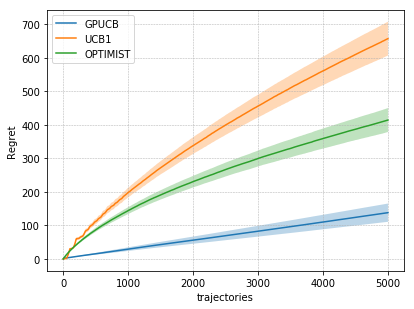

In [192]:
path_opt ="./paper_plots/optimist_lqg/L*"
path_gpucb ="./paper_plots/gpucb_lqg/g*"
path_ucb1 ="./paper_plots/ucb1_lqg/u*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
dfs_list_gpucb, filenames_gpucb = read_csv(path_gpucb)
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
candidates = {'OPTIMIST': dfs_list_opt, 'UCB1': dfs_list_ucb1, 'GPUCB': dfs_list_gpucb}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories')
save_plot(fig, dir='./paper_figures/plots', fname='LQG_mu')
# fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories')
# fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
# fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

## Mu & std

GPUCB: 122.620989 ± 108.264553	[-11.807209, 257.049186]	 total horizon: 5000
UCB1: 646.074448 ± 155.701195	[452.745880, 839.403016]	 total horizon: 5000
OPTIMIST: 477.962016 ± 129.245400	[317.482657, 638.441375]	 total horizon: 5000


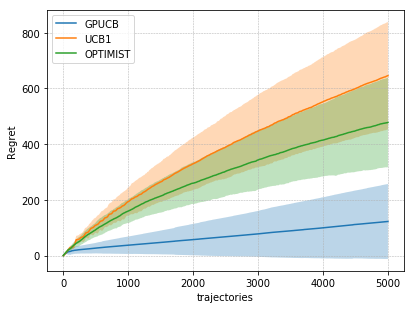

In [194]:
path_opt ="./paper_plots/optimist_lqg_std/L*"
path_gpucb ="./paper_plots/gpucb_lqg_std/g*"
path_ucb1 ="./paper_plots/ucb1_lqg_std/u*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
dfs_list_gpucb, filenames_gpucb = read_csv(path_gpucb)
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
candidates = {'OPTIMIST': dfs_list_opt, 'UCB1': dfs_list_ucb1, 'GPUCB': dfs_list_gpucb}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories')
save_plot(fig, dir='./paper_figures/plots', fname='LQG_mu')
# fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories')
# fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
# fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

# MountainCarContinuous-v0

PBPOIS: 81.021909 ± 7.190305	[72.093967, 89.949851]	 total horizon: 50
PGPE: 87.999884 ± 2.672706	[84.681280, 91.318487]	 total horizon: 50
OPTIMIST: 68.621549 ± 1.434329	[66.840594, 70.402504]	 total horizon: 5000


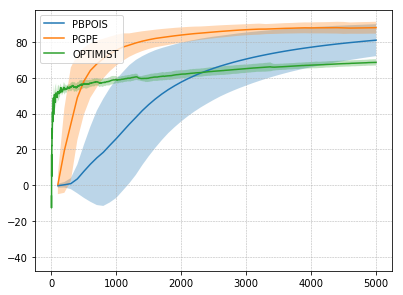

In [193]:
path_opt ="./paper_plots/optimist_mc/M*"
path_pgpe ="./paper_plots/pgpe_mc/MOUNTAINCARCONTINUOUS-V0_step=0.1*"
path_pbp ="./paper_plots/pbpois_mc/M*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
dfs_list_pgpe, filenames_pgpe = read_csv(path_pgpe)
dfs_list_pbp, filenames_pbp = read_csv(path_pbp)

candidates = {'OPTIMIST': dfs_list_opt, 'PGPE': dfs_list_pgpe, 'PBPOIS': dfs_list_pbp}
# candidates = {'OPTIMIST': dfs_listà_opt, 'OPTIMIST_champagne': dfs_list_opt_ch, 'PGPE': dfs_list0}
fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories')

## Heatmap - OPTIMIST

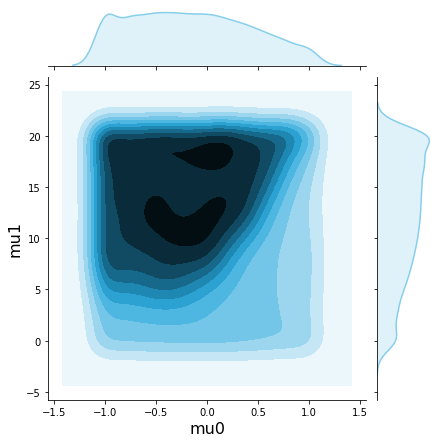

In [172]:
path_opt ="./paper_figures/continuous_setting/mu/mc/optimist_experiment_mc_champagne_posbox/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_13-30-13_2312019_14723.csv"
dfs_list_opt, filenames_opt = read_csv(path_opt)
df = dfs_list_opt[0].fillna(0)
x = df['MountainCar_mu0_higher'].values
y = df['MountainCar_mu1_higher'].values
# df = pd.DataFrame(data=dict(mu0=x, mu1=y)).fillna(0)
import seaborn as sns
h = sns.jointplot(x=x, y=y, kind='kde', color="skyblue")
h.set_axis_labels('mu0', 'mu1', fontsize=16)

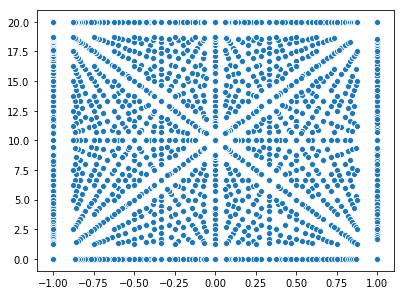

In [165]:
s = sns.scatterplot(x=x, y=y)

## Heatmap - PGPE

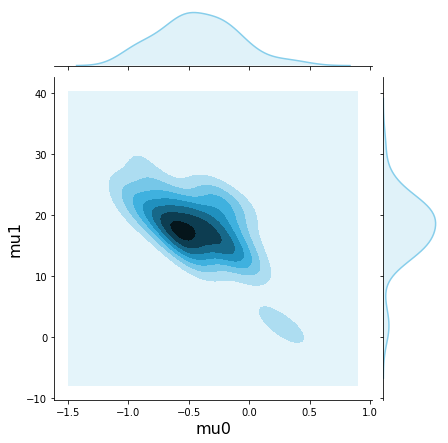

In [176]:
# PGPE
path0 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=0.1_seed=0_11-21-16_2312019_27471.csv"
dfs_list0, filenames0 = read_csv(path0)
x = dfs_list0[0]['MountainCar_mu0_higher'].values
y = dfs_list0[0]['MountainCar_mu1_higher'].values
import seaborn as sns
h = sns.jointplot(x=x, y=y, kind='kde', color="skyblue")
h.set_axis_labels('mu0', 'mu1', fontsize=16)

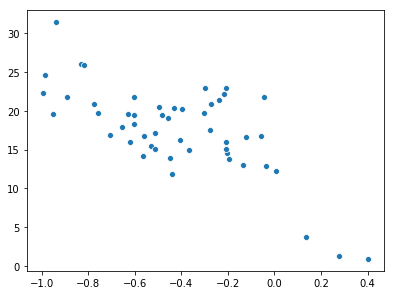

In [157]:
s = sns.scatterplot(x=x, y=y)